# Differential equations

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

You will be encountered with a variety of dynamical systems (systems that chage with time) as long as you live as engineers. Differential equations are the core mathematical tools that can be used to describe dynamical systems.

In this lecture, we will talk about how we can express differential equations in Python and how we can solve (numerically integrate) them.

In addition to `numpy` and `matplotlib.pyplot` we will import `scipy.integrate` module which provides a couple of handy tools for numerical integration.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as spi

### LRC circuits

For example, a series LRC curcuit below can be described by,

<center>
<img src="https://farm3.staticflickr.com/2947/15494260036_902e32f36d_o.png" width="280">
</center>

\begin{align*}
  C\dot{V}_C &= I \\
  L\dot{I} &= V_{in}-V_{C}-IR  
\end{align*}

where $L$, $R$, and $C$ are somethings all of you are very familiar with. Or by eleminating $I$ we have that

<br>

\begin{align*}
  LC\ddot{V}_C + RC\dot{V}_C + V_C &= V_{in}
\end{align*}

<br>

In general, we can express any $n$-th order ordinary differential equations by a system of $n$ first order ordinary differential equations with $n$ state variables (the state variables were $V_C$ and $I$ in the above system). Also note that the derivatives of the state variables, $\dot{V}_C$ and $\dot{I}$, are linear in the state variables, so this is a set of _linear_ ordinary differential equations.

The set of differential equations imply that if you are given the initial value for the state variables, which is $V_C$ and $I$ at $t=0$, you will be able to compute $V_C(t)$ and $I(t)$, by integrating the differential equations, for any $t>0$ you are interested in, as long as you know $V_{in}(\tau)$ for $0\le \tau< t$.

The following code simulates the response of $V_C$ and $I$ to a short pulse of $V_{in}$ as follows.

<br>

$$
V_{in}(t)=
\begin{cases}
5 \qquad \text{if } 25 \le t \le 100 \mu s\\
0 \qquad \text{otherwise}
\end{cases}
$$

<br>



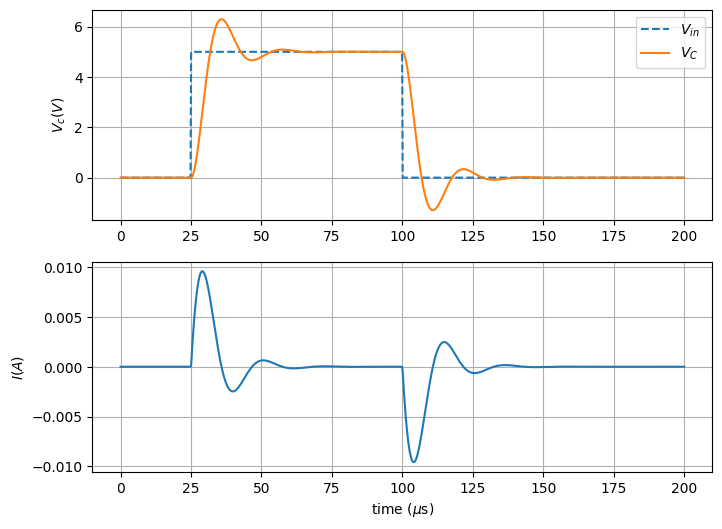

In [ ]:
L = 1e-3       # inductance: 1mH
C = 10e-9      # capacitance: 10nF
R = 250        # resistance: 250ohm

# function that returns dz/dt=[Vcdot, Idot]
def model(z,t):
  Vc, I = z
  Vcdot = I/C
  if (t>25e-6 and t<=100e-6):
    Vin = 5
  else:
    Vin = 0
  Idot = (Vin-Vc-I*R)/L
  return np.array([Vcdot, Idot])

# initial condition
ic = [0, 0]
# time points
t = np.linspace(0,200e-6,1000)
u = np.zeros(1000)
u[125:500] = 5;
# solve ODE
states = spi.odeint(model,ic,t)

# plot results
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t*10**6, u, '--', label=r'$V_{in}$')
plt.plot(t*10**6, states[:,0], label=r'$V_C$')
plt.legend()
plt.grid()
plt.ylabel(r'$V_c (V)$')
plt.subplot(212)
plt.plot(t*10**6, states[:,1])
plt.xlabel(r'time ($\mu$s)')
plt.ylabel(r'$I (A)$')
plt.grid()
plt.show()

### Raindrops

We will talk about another example. We consider a stationary object at altitiude $h(0)$, and suppose it is falling freely due to gravity. Then its future altitude can be described by

<br>

\begin{aligned}
  \dot{h} &= v \\
  \dot{v} &=-g
\end{aligned}

<br>

which is trivial and can be easily solved analytically. Integrating once would give the vertical velocity by

<br>

$$ v = v(0) -gt = -gt$$

<br>

and integrating once again would give the altitude

<br>

$$ h = h(0) - 0.5gt^2$$

<br>

Now suppose $h(0)=2000m$ and $g=10m/s^2$, then

<br>

$$
  h(20) = 2000-0.5\times 10\times 20\times 20 = 0
$$

<br>

which implies the object falling from $h(0)=2000m$ whould hit the ground at $t=20 (sec)$, and the velocity when the object hits the ground is

$$v(20)=|\dot{h}(20)| =10\times20 = 200 m/s$$

The above example was an extremely simple linear differential equation, which you were able to solve analytically. The code below will check if your analytic solution is correct.

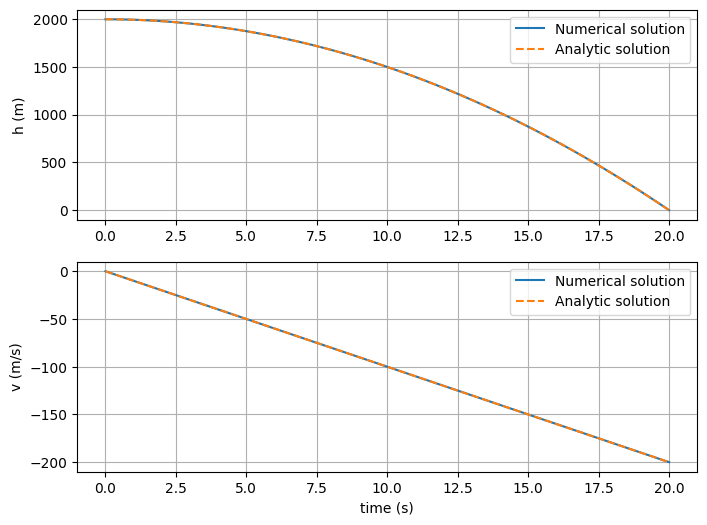

In [ ]:
Cd = 1.0  # drag coefficient

# function that returns dy/dt=[hdot, vdot]
def model(z,t):
  h, v = z                # h (altitude) and v (altitude rate)
  hdot = v                # dh/dt
  vdot = -10              # dv/dt
  return np.array([hdot, vdot])

# initial condition
ic = [2000, 0]
# time points
t = np.linspace(0,20,100)

# solve ODE
states = spi.odeint(model,ic,t)

# plot results
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t, states[:,0], label='Numerical solution')
plt.plot(t, 2000-0.5*10*t*t, '--', label='Analytic solution')
plt.ylabel('h (m)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t, states[:,1], label='Numerical solution')
plt.plot(t, -10*t, '--', label='Analytic solution')
plt.xlabel('time (s)')
plt.ylabel('v (m/s)')
plt.legend()
plt.grid()
plt.show()

So your two solutions match, which is good. But look, this is insane because it says that the raindrops formed at 2km will fall to the ground with $v=200m/s$. Those will kill everyone on the ground.

The absurdity has arisen since we ignored the drag force acting on the body.

We can add the drag force to build a more reliable model for the falling object.

<br>

\begin{aligned}
\dot{h} &= v \\
\dot{v} &= -g + 0.5\rho v^2 S C_D/m
\end{aligned}

<br>

where $m$, $S$ and $C_D$ stand for the mass, the characteristic aera and the drag coefficient of the object, which we assume constant. Another variable $\rho$ stands for the air density which is a function of altitude, $h$, and can be approximated in a reasonable accuracy up to $h<18km$ by following.

<br>

$$
  \rho(h) = 1.225 \left(1-2.256\times 10^{-5}h \right)^{5.256}
$$

<br>

So the drag force quickly increases as the velocity increases and the raindrop approaches close to the ground.

The above is a highly nonlinear differential equation and is extremely hard to solve analytically. However, solving numerically is not that hard.

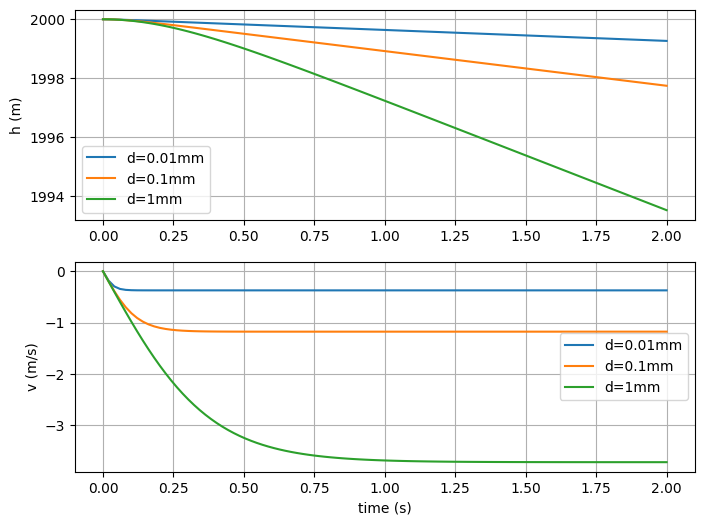

In [ ]:
Cd = 1.0  # drag coefficient

# function that returns dy/dt=[hdot, vdot]
def model(z,t,d):
  S = np.pi*d**2/4                  # cross-section area of the droplet
  m = np.pi*d**3/6*1000             # mass of the droplet
  h, v = z                          # h (altitude) and v (altitude rate)
  hdot = v                          # dh/dt
  rho = 1.225*(1-2.256e-5*h)**5.256 # air density
  vdot = -10 + 0.5*rho*v*v*S*Cd/m   # dv/dt
  return np.array([hdot, vdot])

# initial condition
ic = [2000, 0]
# time points
t = np.linspace(0,2,100)

# solve ODEs
d = 0.01e-3
states1 = spi.odeint(model,ic,t,args=(d,))
d = 0.1e-3
states2 = spi.odeint(model,ic,t,args=(d,))
d = 1e-3
states3 = spi.odeint(model,ic,t,args=(d,))

# plot results
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(211)
plt.plot(t, states1[:,0], label='d=0.01mm')
plt.plot(t, states2[:,0], label='d=0.1mm')
plt.plot(t, states3[:,0], label='d=1mm')
plt.ylabel('h (m)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t, states1[:,1], label='d=0.01mm')
plt.plot(t, states2[:,1], label='d=0.1mm')
plt.plot(t, states3[:,1], label='d=1mm')
plt.xlabel('time (s)')
plt.ylabel('v (m/s)')
plt.legend()
plt.grid()
plt.show()


The raindrops reach the terminal velocity very quickly ($<2 \sec$), and they fall to the ground rather softly, not $v=200m/s$. Now the results make sense and they match with your intuition and experiences.

<br>


### Numerical integration

In fact, computing numerical integration is not so hard without `scipy.integrate` submodule, since

$$
y(t+\Delta t) \approx y(t) + \Delta t \dot{y}(t)
$$

for very small $\Delta t$. This implies you can predict the future $y$ if you know the current $y$ and $\dot{y}$, and directly gives the Euler integration method.


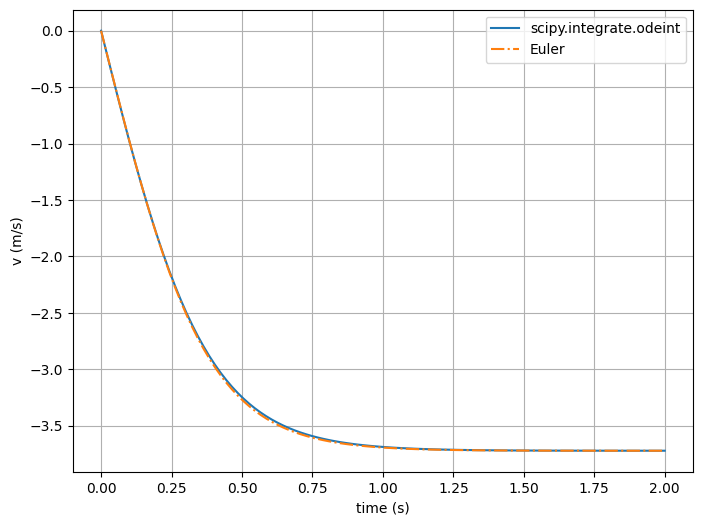

In [ ]:
T = len(t)
dt = t[-1]/T

# solve ODEs using Euler integration
states3_e = np.zeros((T,2))
states3_e[0,:] = ic

for k in range(T-1):
  states3_e[k+1,:] = states3_e[k,:] + dt*model(states3_e[k,:],t[k],1.00e-3)

# plot results
plt.figure(figsize=(8,6), dpi=100)
plt.plot(t, states3[:,1], label='scipy.integrate.odeint')
plt.plot(t, states3_e[:,1], '-.', label='Euler')
plt.xlabel('time (s)')
plt.ylabel('v (m/s)')
plt.legend()
plt.grid()
plt.show()

<br>

A little more accurate way is to use more past values, as illustrated by the two-step Adams–Bashforth method.

$$
y(t+\Delta t) \approx y(t) + \frac{1}{2}\Delta t \left\{ 3\dot{y}(t) - \dot{y}(t-\Delta t) \right\}
$$

This leads to the family of linear multistep methods.


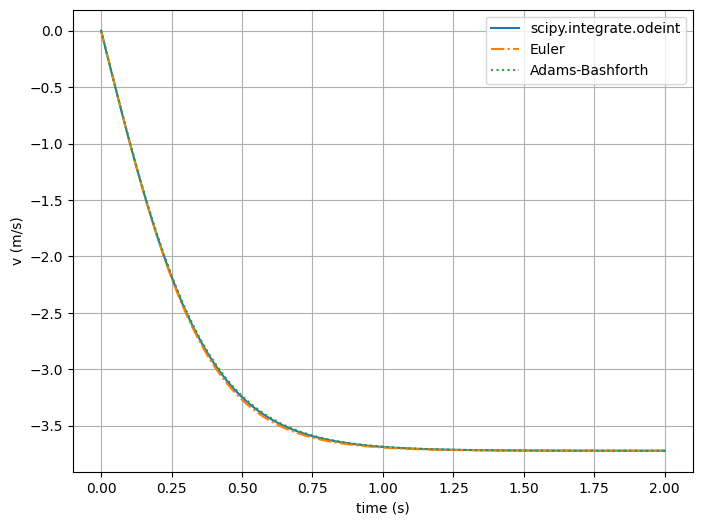

In [ ]:
# solve ODEs using Adams-Bashforth integration
states3_ab = np.zeros((T,2))
states3_ab[0,:] = ic
deriv_p = model(states3_ab[0,:],t[0],1.00e-3)
for k in range(T-1):
  deriv = model(states3_ab[k,:],t[k],1.00e-3)
  states3_ab[k+1,:] = states3_ab[k,:] + 0.5*dt*(3*deriv - deriv_p)
  deriv_p = deriv

# plot results
plt.figure(figsize=(8,6), dpi=100)
plt.plot(t, states3[:,1], label='scipy.integrate.odeint')
plt.plot(t, states3_e[:,1], '-.', label='Euler')
plt.plot(t, states3_ab[:,1], ':', label='Adams-Bashforth')
plt.xlabel('time (s)')
plt.ylabel('v (m/s)')
plt.legend()
plt.grid()
plt.show()